In [10]:
import pandas as pd

# 데이터 불러오기!
train_df = pd.read_csv('data/train.csv')
test_y = pd.read_csv('data/test.csv')
"""
pressure 압력
maxtemp 최대온도
temperature 온도
mintemp 최소온도
dewpoint 이슬점
humidity 습기
cloud 구름
sunshine 햇빛
wind direction 바람의 방향
wind speed 풍속
rainfall 강우
"""
train_df = train_df.drop(columns=['id', 'day', 'winddirection'])
test_y = test_y.drop(columns=['id', 'day', 'winddirection'])

# ㅈ대로하는 피처 엔지니어링 .
# humity, sunshine
# train_df['3colmns'] = train_df['dewpoint'] + train_df['cloud'] + train_df['humidity']

# train_df['cloudshine'] = train_df['sunshine'] / train_df['cloud']
# test_y['cloudshine'] = test_y['sunshine'] / test_y['cloud']
# train_df['dewpointhumidity'] = train_df['cloud'] + train_df['dewpoint']
# test_y['dewpointhumidity'] = test_y['cloud'] + test_y['dewpoint']
# test_y['cloudhumidity'] = test_y['cloud'] * test_y['humidity']

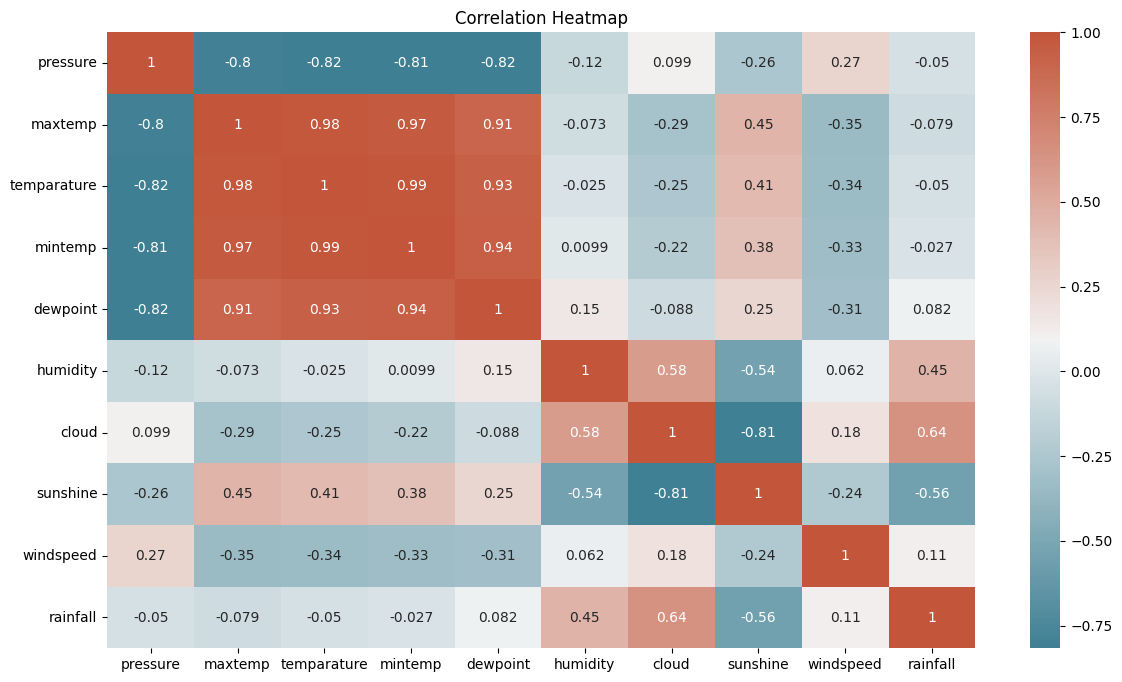

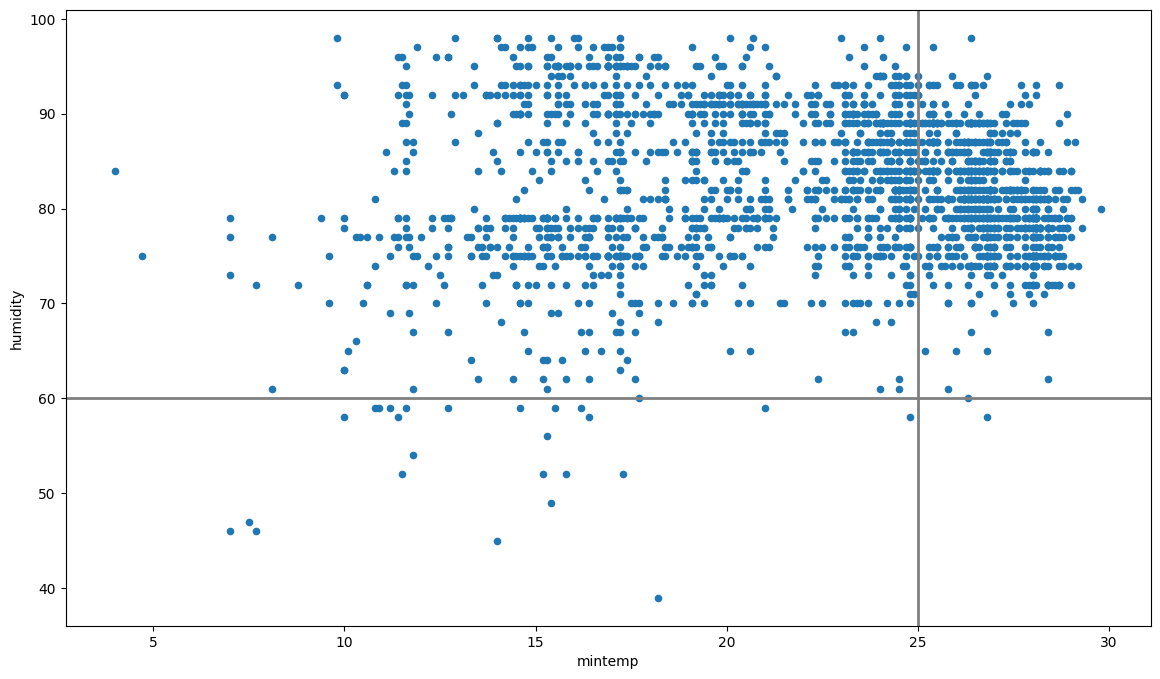

In [11]:
# 일변량 분석
# train_df = train_df[train_df['rainfall']==1]
# print(train_df)

df = train_df.select_dtypes(include=['number'])

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 8)

corr_matrix = df.corr()

# print(corr_matrix.loc[corr_matrix['Transported'].abs() >= 0.1].index.tolist())
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

ax = train_df.plot.scatter(x='mintemp', y='humidity')
ax.axhline(60, color='gray', lw=2)
ax.axvline(25, color='gray', lw=2)

Text(0, 0.5, 'humidity')

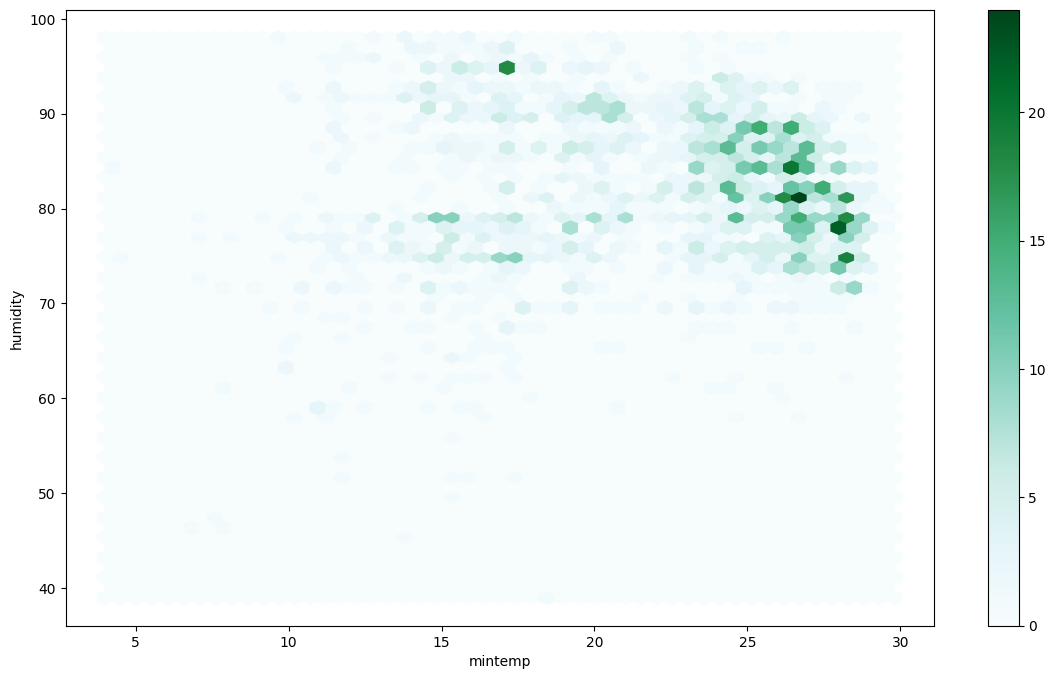

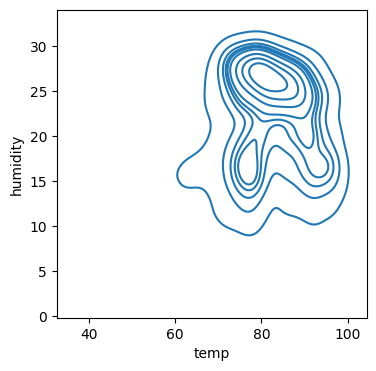

In [12]:
# 다변량 분석
train_df.plot.hexbin(x='mintemp', y='humidity', gridsize=50, sharex=False)
ax.set_xlabel('FInished min temp')
ax.set_ylabel("temperature")

fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.kdeplot(data=train_df, x='humidity', y='mintemp', ax=ax)
ax.set_xlabel('temp')
ax.set_ylabel('humidity')



In [ ]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier, LGBMRegressor



X = train_df.select_dtypes(include=['number'])
y = train_df.rainfall
X = X.drop(columns=['rainfall'])

cat_model = CatBoostRegressor(iterations=500, learning_rate=0.04, depth=5, verbose=0)
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.04, max_depth=3, eval_metric='auc')
svm_model = SVC(probability=True, kernel='rbf', C=1.0)
knn_model = KNeighborsClassifier(n_neighbors=5)
lgbm_model = LGBMRegressor(objective='binary', metric='auc')

estimators = [
    ('cat', cat_model),
    ('lgbm', lgbm_model),
    ('xgb', xgb_model)
]

from sklearn.metrics import roc_auc_score



model = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor(n_estimators=100))
test_y = test_y[X.columns].fillna(0)
test_y = test_y.select_dtypes(include=['number'])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)



model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# print("Val accuracy after pseudo labeling:", accuracy_score(y_val, y_pred))
auc = roc_auc_score(y_val, y_pred)
print("ROC AUC:", auc)

# 7. 최종 테스트셋 예측
final_pred = model.predict(test_y)
# ROC AUC: 0.8689600840336135

[LightGBM] [Info] Number of positive: 1242, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 1642, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.756395 -> initscore=1.133014
[LightGBM] [Info] Start training from score 1.133014
[LightGBM] [Info] Number of positive: 986, number of negative: 327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 1313, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750952 -> initscore=1.103696
[LightGBM] [Info] Start training from score 1.103696
[LightGBM] [Info] Number of

In [14]:
template_df = pd.read_csv('data/test.csv')
dd = template_df['id']

# int(dd)
ddf = pd.Series(final_pred, name='rainfall')
# ddf = ddf.map({0: 'False', 1: 'True'})
ds = pd.concat([dd ,ddf], axis=1)
print(ds)
ds.to_csv("result.csv", index=False)

       id  rainfall
0    2190  0.988621
1    2191  0.976388
2    2192  0.972064
3    2193  0.228605
4    2194  0.078137
..    ...       ...
725  2915  0.988621
726  2916  0.899726
727  2917  0.991024
728  2918  0.988621
729  2919  0.954635

[730 rows x 2 columns]
